# Despeckling of Medical Ultrasound Images
<em>Oleg V. Michailovich and Allen Tannenbaum, Member, IEEE (http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3639001/)</em>

Pre-Processing:

1)	Radio-Frequency (RF) Image subject to a spectrum equalization procedure. (Decorrelate the image samples)

2)	Log-Transformed Envelope Image is passed through a nonlinear outlier-shrinkage procedure. (Suppress the spiky component of the log-transformed speckle noise)



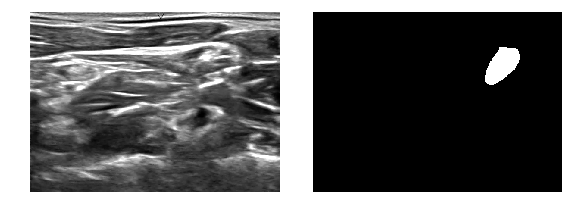

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage
import os
from skimage import io
from skimage import img_as_float
image = io.imread('1_1.tif')
mask = io.imread('1_1_mask.tif')
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.axis('off')
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.subplot(122)
plt.axis('off')
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()

#### 1. RF-Image Modeling and Equalization


RF-image is considered to be a result of the convolution of the point-spread function (PSF) of the imaging system with the tissue reflectivity function. Denoting by g(n, m), f(n, m), and h(n, m) the RF-image, the tissue reflectivity function, and the PSF, respectively, the convolution model is formally given by:

$$g(n,m)=f(n,m)∗h(n,m)+u(n,m)$$

$n$ and $m$ denote the axial and lateral (or radial and angular, for B-scan sector images) indices of the image samples
$u(n, m)$ is added to describe measurement noises as well as all the physical phenomena, which are not accounted for by the convolution model.

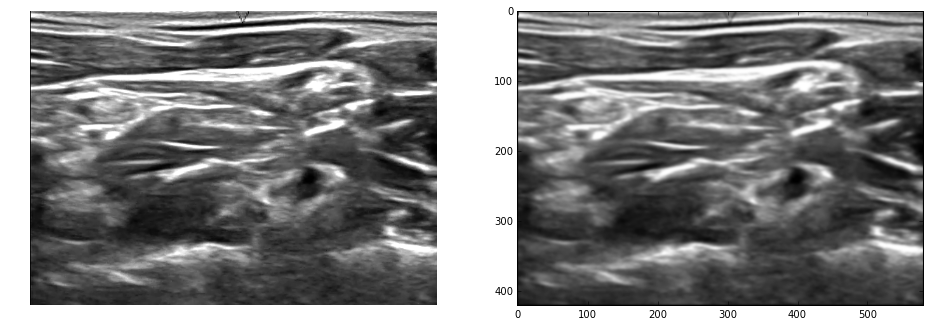

In [4]:
[rows, cols]=image.shape
diff = img_as_float(image) # original image
lambdav = 0.1
niter = 50
Co = 2
for i in range(0,10): #1:10  # iterations
    # Construct diffl which is the same as diff but
    # has an extra padding of zeros around it.
    diffl = np.zeros((rows+2, cols+2))
    diffl[1:rows+1, 1:cols+1] = diff

    #North, South, East and West differences
    deltaN = diffl[0:rows,1:cols+1]   - diff
    deltaS = diffl[2:rows+2,1:cols+1] - diff
    deltaE = diffl[1:rows+1,2:cols+2] - diff
    deltaW = diffl[1:rows+1,0:cols]   - diff

    p1 = np.power(deltaN/Co,2)
    p2 = np.power(deltaS/Co,2)
    p3 = np.power(deltaE/Co,2)
    p4 = np.power(deltaW/Co,2)
    
    cN = np.divide(1,(1 + p1))
    cS = np.divide(1,(1 + p2))
    cE = np.divide(1,(1 + p3))
    cW =np.divide(1,(1 + p4))

    diff = diff + lambdav*(np.multiply(cN,deltaN) + np.multiply(cS,deltaS) + np.multiply(cE,deltaE) + np.multiply(cW,deltaW))

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.imshow(diff, cmap='gray')
plt.show()

In [51]:
import numpy as np
import warnings

def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,ploton=False):
    """
    Anisotropic diffusion.

    Usage:
    imgout = anisodiff(im, niter, kappa, gamma, option)

    Arguments:
            img    - input image
            niter  - number of iterations
            kappa  - conduction coefficient 20-100 ?
            gamma  - max value of .25 for stability
            step   - tuple, the distance between adjacent pixels in (y,x)
            option - 1 Perona Malik diffusion equation No 1
                     2 Perona Malik diffusion equation No 2
            ploton - if True, the image will be plotted on every iteration

    Returns:
            imgout   - diffused image.

    kappa controls conduction as a function of gradient.  If kappa is low
    small intensity gradients are able to block conduction and hence diffusion
    across step edges.  A large value reduces the influence of intensity
    gradients on conduction.

    gamma controls speed of diffusion (you usually want it at a maximum of
    0.25)

    step is used to scale the gradients in case the spacing between adjacent
    pixels differs in the x and y axes

    Diffusion equation 1 favours high contrast edges over low contrast ones.
    Diffusion equation 2 favours wide regions over smaller ones.

    Reference: 
    P. Perona and J. Malik. 
    Scale-space and edge detection using ansotropic diffusion.
    IEEE Transactions on Pattern Analysis and Machine Intelligence, 
    12(7):629-639, July 1990.

    Original MATLAB code by Peter Kovesi  
    School of Computer Science & Software Engineering
    The University of Western Australia
    pk @ csse uwa edu au
    <http://www.csse.uwa.edu.au>

    Translated to Python and optimised by Alistair Muldal
    Department of Pharmacology
    University of Oxford
    <alistair.muldal@pharm.ox.ac.uk>

    June 2000  original version.       
    March 2002 corrected diffusion eqn No 2.
    July 2012 translated to Python
    """

    # ...you could always diffuse each color channel independently if you
    # really want
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype('float32')
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in range(niter):

        # calculate the diffs
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-(deltaS/kappa)**2.)/step[0]
            gE = np.exp(-(deltaE/kappa)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaS/kappa)**2.)/step[0]
            gE = 1./(1.+(deltaE/kappa)**2.)/step[1]

        # update matrices
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]

        # update the image
        imgout += gamma*(NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return imgout





0.1591510772705078


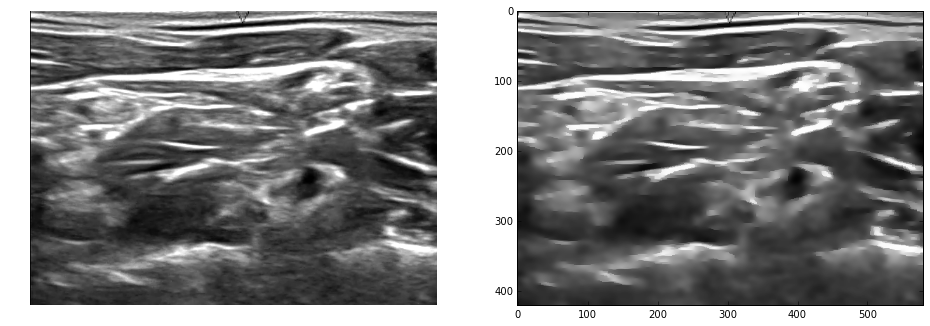

In [185]:
import matplotlib
import time
%matplotlib inline
import matplotlib.pyplot as plt
#kapp = 4 and gamma = 2 looks good..
# niter=240,kappa=20,gamma=.25,option=1
# niter=240,kappa=10,gamma=.4,option=1 @ 5000 itr even better, 50000 even better.
start = time.time()
result = anisodiff(image, niter=25,kappa=10,gamma=.25,option=1)
end = time.time()
print(end - start)
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.imshow(result, cmap='gray')
plt.show()

# import matplotlib.image as mpimg
# mpimg.imsave("result2.png", result)